# Data Spaces Thesis

### Importing the Dataset

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("heart.csv")
#print(df.info())
#print(df.describe())  # description of statistic features

## 1. Dataset Analysis

### Preprocessing

Data Preprocessing - OneHot Encoding
There are categorical data, we have to deal with!
One hot encoding is a representation of categorical variables as binary vectors.
Categorical Features are: cp, restecg, slope, thal
Transforming columns corresponding to categorical features into one hot.
see https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [24]:
categorical_features = ['cp', 'restecg', 'slope', 'thal']
for feature in categorical_features:
    num_classes = len(df[feature].unique())
    curr_onehot = pd.get_dummies(df[feature], prefix='en_' + feature)
    df = df.drop(feature, axis=1)
    df = df.join(curr_onehot)

In [25]:
from sklearn.preprocessing import StandardScaler

X = df[df.columns[:-1]].values  # from encoded dataframe
y = df["target"].values

# Fai vedere come non normalizzando c'è outlier a (300, -10)
X_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X)  # Normalization: Mean=0; Variance=1

### Principle Component Analysis

PCA on normalized dataset:
Explained Variance Ratio by the first component: 19.782%
Explained Variance Ratio by the first 2 components: 28.669%
Explained Variance Ratio by the first 6 components: 54.507%
Explained Variance Ratio by the first 10 components: 73.286%


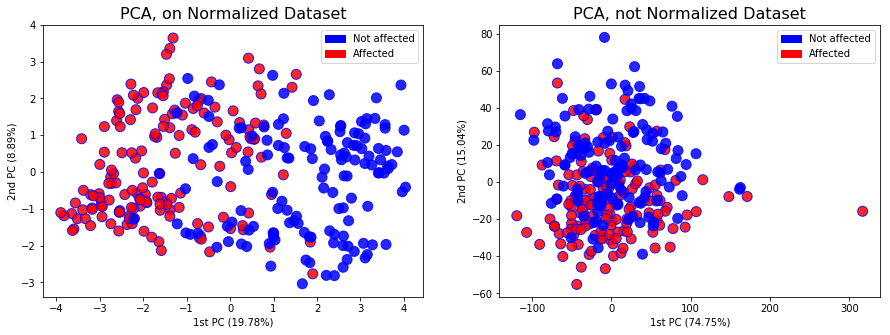

In [32]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

pca, pca1 = PCA(), PCA() # all components
X_t = pca.fit_transform(X_std)  # with normalization
X_t1 = pca1.fit_transform(X)  # without normalization, presence of Outliers, this impact on PC1 p.v.e

# Explained variance ratios
# PCA on normalized dataset
first_1 = 0; first_2 = 0; first_6 = 0; first_10 = 0
for e in pca.explained_variance_ratio_[:1]:
    first_1+= e
for e in pca.explained_variance_ratio_[:2]:
    first_2 += e
for e in pca.explained_variance_ratio_[:6]:
    first_6 += e
for e in pca.explained_variance_ratio_[:10]:
    first_10 += e
print('PCA on normalized dataset:')
print("Explained Variance Ratio by the first component: %.03f%%" % (first_1 * 100))
print("Explained Variance Ratio by the first 2 components: %.03f%%" % (first_2 * 100))
print("Explained Variance Ratio by the first 6 components: %.03f%%" % (first_6 * 100))
print("Explained Variance Ratio by the first 10 components: %.03f%%" % (first_10 * 100))

# Label to color dict (manual)
label_color_dict = {0: 'blue', 1: 'red'}
# Color vector creation
cvec = [label_color_dict[label] for label in y]
# Legend
negative_patch = mpatches.Patch(color='blue', label='Not affected')
positive_patch = mpatches.Patch(color='red', label='Affected')
# 1st and 2nd Components Scatter
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.set_xlabel('1st PC (%.2f%%)' % (pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('2nd PC (%.2f%%)' % (pca.explained_variance_ratio_[1] * 100))
ax.set_title('PCA, on Normalized Dataset', fontsize=16)
ax.scatter(X_t[:, 0], X_t[:, 1], c=cvec, edgecolor='b', alpha=0.85, s=100)
ax.legend(handles=[negative_patch, positive_patch])
ax1 = fig.add_subplot(122)
ax1.set_xlabel('1st PC (%.2f%%)' % (pca1.explained_variance_ratio_[0] * 100))
ax1.set_ylabel('2nd PC (%.2f%%)' % (pca1.explained_variance_ratio_[1] * 100))
ax1.set_title('PCA, not Normalized Dataset', fontsize=16)
ax1.scatter(X_t1[:, 0], X_t1[:, 1], c=cvec, edgecolor='b', alpha=0.85, s=100)
ax1.legend(handles=[negative_patch, positive_patch])
plt.show()

### Considerations

## 2. Classification

Spiegare cross validation: ...
    

Utility Functions for decision regions plotting:

In [33]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

Splitting the dataset into Training Set and Test Set

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.3, random_state=0)

### 2.1 K-Nearest Neighbour 

https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

k_values = [1, 2, 3, 6, 9, 12, 20, 30]
weights_values = ["uniform", "distance"]
tuned_parameters = {'n_neighbors': k_values, 'weights': weights_values}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, tuned_parameters , cv=5, refit=True, return_train_score=True)
clf.fit(X_train, y_train)
print('GridSearchCV 5-Fold on Training Set')
print('Best_parameters are: ', clf.best_params_)

# Remember that this time we are doing cross validation with k=5 to choose
# the best parameters ==> we get mean_score
# Mean cross-validated score of the best_estimator
accuracy = 100 * float(clf.best_score_)
print('Accuracy Score (AVG on all folds scores) is: %.03f%% ' % accuracy)

# best estimator is accessible by "clf.best_estimator_" if refit=TRUE
y_pred = clf.best_estimator_.predict(X_test)
score = 100 * metrics.accuracy_score(y_test, y_pred)
print("clf - With best params from GridSearchCV [%d , %s]\nAccuracy Score on Test Set is %.2f%%" %
      (clf.best_params_['n_neighbors'], clf.best_params_['weights'], score))

GridSearchCV 5-Fold on Training Set
Best_parameters are:  {'n_neighbors': 12, 'weights': 'uniform'}
Accuracy Score (AVG on all folds scores) is: 91.981% 
clf - With best params from GridSearchCV [12 , uniform]
Accuracy Score on Test Set is 93.41%


In [39]:
k_test_scores = []  # scores on Test Set for different K values, with 'uniform' weights
clf_vect = []  # vector containing fitted classifier for each k value
for k in k_values:
    curr_clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    curr_clf.fit(X_train, y_train)
    clf_vect.append(curr_clf)
    y_pred = curr_clf.predict(X_test)
    score = 100 * metrics.accuracy_score(y_test, y_pred)
    k_test_scores.append(score)

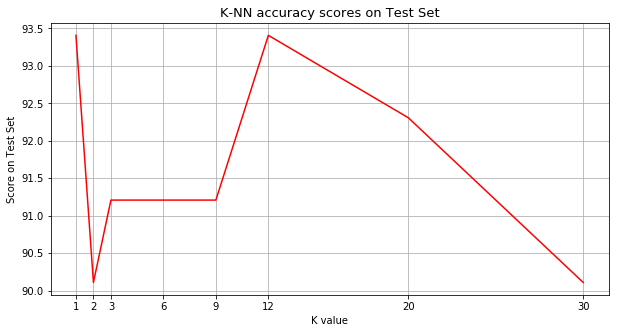

In [40]:
# Graph showing how the accuracy varies when changing K in KNN
fig = plt.figure(figsize=(10,5))
plt.title('K-NN accuracy scores on Test Set', fontsize=13)
ax = fig.add_subplot(1, 1, 1)
ax.plot(k_values, k_test_scores, color='red')
ax.set(xlabel='K value', ylabel='Score on Test Set')
ax.set_xticks(k_values)
ax.grid()
plt.show()

In [44]:
# we create an instance of Neighbours Classifier and fit the data.
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = 0.2
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
Z = clf.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("knn classification (k = %d)" % k)

ValueError: query data dimension must match training data dimension